# Differential Analysis of Ribo vs DNA-only runs
Here several plots are produces to visulize better aligment profile is search for noise into data when comparing DNA-only control run with the Ribo1.

In [1]:
# import basic modules
import os, glob, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam

# define utils function
def get_complement(seq):
    dict_ = {"A":"T", "T":"A", "G":"C", "C":"G"}
    complement = [dict_[base] for base in seq]
    return complement

In [2]:
# define results folder and print files
results_folder = "/lustre/bio_running/DNA_Ribo/results/basecalling_features_with_raw_data"
reference_filepath = "/lustre/bio_running/DNA_Ribo/refs/ref.fa"

# create a folder where to store resulting differential dna-ribo plots
results_folder_diff_plots = os.path.join(results_folder, "diff_plots")

# create results folder if it doesn't exists
if not os.path.exists(results_folder_diff_plots):
    os.mkdir(results_folder_diff_plots)

# list files into raw data results folder
os.listdir(results_folder)

['DNA only vs Ribo1 rep2 site M13mp18:4985.ribo.rev.tsv',
 'DNA only vs Ribo1 rep2 site M13mp18:4985.dna.forw.tsv',
 'DNA only vs Ribo1 rep2 site M13mp18:5015.dna.forw.tsv',
 'DNA only vs Ribo2 rep1 site M13mp18:4899.dna.forw.tsv',
 'diff_plots',
 'DNA only vs Ribo1 site M13mp18:5015.ribo.rev.tsv',
 'DNA only vs Ribo2 rep2 site M13mp18:4899.ribo.rev.tsv',
 'DNA only vs Ribo1 site M13mp18:5004.dna.forw.tsv',
 'DNA only vs Ribo1 site M13mp18:5004.ribo.rev.tsv',
 'DNA only vs Ribo1 site M13mp18:4997.tiff',
 'DNA only vs Ribo1 site M13mp18:5004.ribo.forw.tsv',
 'DNA only vs Ribo1 rep2 site M13mp18:5004.dna.forw.tsv',
 'DNA only vs Ribo2 rep1 site M13mp18:4915.dna.rev.tsv',
 'DNA only vs Ribo1 rep2 site M13mp18:4985.ribo.forw.tsv',
 'DNA only vs Ribo3 site M13mp18:4832.ribo.forw.tsv',
 'DNA only vs Ribo1 rep2 site M13mp18:5015.dna.rev.tsv',
 'DNA only vs Ribo2 rep1 site M13mp18:4899.dna.rev.tsv',
 'DNA only vs Ribo1 site M13mp18:4997.ribo.forw.tsv',
 'DNA only vs Ribo3 site M13mp18:4822.dna

## DNA vs Ribo1 rep1 02 07 2022

Barplot version with single variables

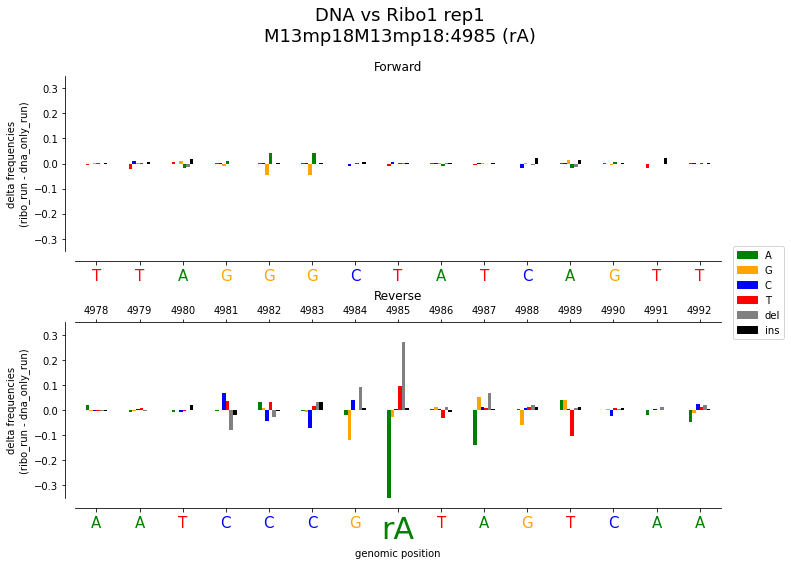

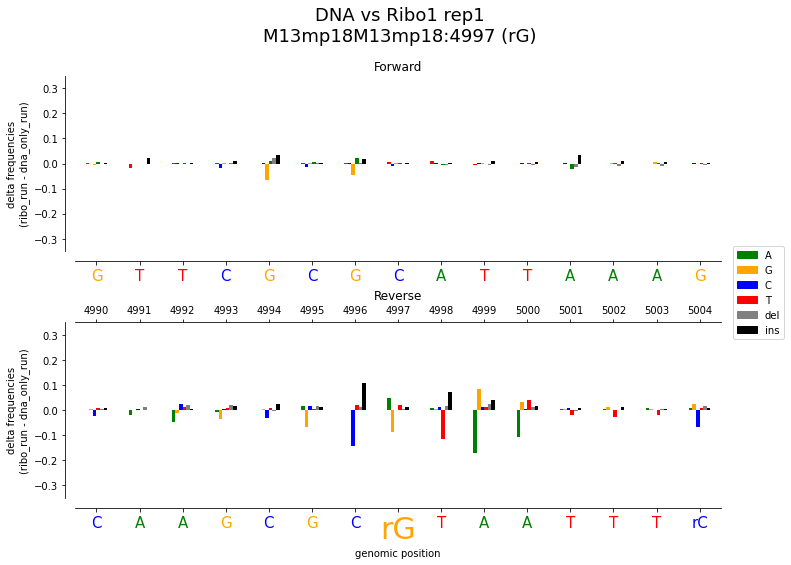

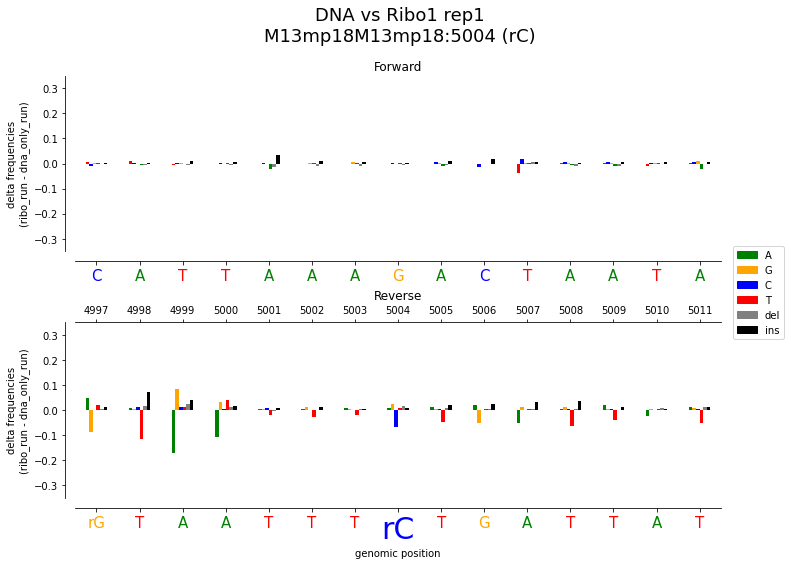

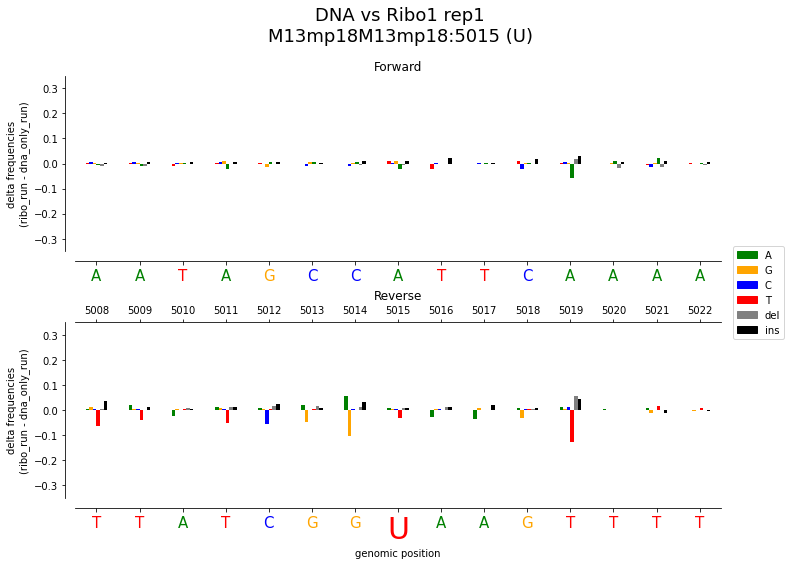

In [3]:
# open reference with pysam as FastaFile object
ref = pysam.FastaFile(reference_filepath)

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4985, 4997, 5004, 5015]

# define ribo names
ribos = ["rA", "rG", "rC", "U"]

# define color code
color_code = {"A":"green", "G":"orange", "C":"blue", "T":"red", "rA":"green", "rG":"orange", "rC":"blue", "U":"red", "ins":"black", "del":"gray"}

# load alignment profiles for dna and ribo for each expected "ribo" site
columns_forw = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'T', 'C', 'G', 'A', 'del', 'ins']
columns_rev = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'A', 'G', 'C', 'T', 'del', 'ins']
for ribo, site in zip(ribos, sites):
    dna_forw = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.dna.forw.tsv"))[0], index_col=0)
    dna_forw.columns = columns_forw
    dna_rev = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.dna.rev.tsv"))[0], index_col=0)
    dna_rev.columns = columns_rev
    ribo_forw = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.ribo.forw.tsv"))[0], index_col=0)
    ribo_forw.columns = columns_forw
    ribo_rev = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.ribo.rev.tsv"))[0], index_col=0)
    ribo_rev.columns = columns_rev
    
    # calculate differential frequencies between dna_only and ribo runs at each strand
    forw_freqs_diffs = ribo_forw.iloc[:,-6:] - dna_forw.iloc[:,-6:]
    rev_freqs_diffs = ribo_rev.iloc[:,-6:] - dna_rev.iloc[:,-6:]
    
    # retrieve reference sequences
    start, stop = forw_freqs_diffs.index.min()-1, forw_freqs_diffs.index.max()
    seq = ref.fetch("M13mp18", start, stop)
    seq_rev_compl = get_complement(seq)
    
    # convert to lists
    seq = list(seq)
    seq_rev_compl = list(seq_rev_compl)
    # change central base since it is an expected nucleotide
    if not seq_rev_compl[7] == "T":
        seq_rev_compl[7] = "r"+seq_rev_compl[7]
    else:
        seq_rev_compl[7] = "U"
    # considers sites 4997 and 5004 are in overlap
    if site == 4997:
        seq_rev_compl[-1] = "rC"
    elif site == 5004:
        seq_rev_compl[0] = "rG"
    
    # take maximum absolute values of differences in both strand to be used to determine y intervals into plots
    max_abs_freq  = max(forw_freqs_diffs.abs().max().max(), rev_freqs_diffs.abs().max().max())
    if max_abs_freq < 0.35:
        max_abs_freq = 0.35
    
    ### plot differential alignment profiles
    # create a subplot for each site
    f, axes = plt.subplots(2, figsize=(10,7), constrained_layout=True)
    
    # plot forward strand
    #axes[0].axhline(0,0,1, linewidth=0.5, color="gray")
    # change index labels
    forw_freqs_diffs.index = seq
    forw_freqs_diffs.plot(kind="bar", ax=axes[0], color=[color_code[i] for i in forw_freqs_diffs.columns])
    axes[0].set_title("Forward")
    axes[0].set_ylim([-max_abs_freq, max_abs_freq])
    axes[0].legend().set_visible(False)
    # Move left and bottom spines outward by 10 points
    axes[0].spines.left.set_position(('outward', 10))
    axes[0].spines.bottom.set_position(('outward', 10))
    # Hide the right and top spines
    axes[0].spines.right.set_visible(False)
    axes[0].spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[0].yaxis.set_ticks_position('left')
    axes[0].xaxis.set_ticks_position('bottom')
    axes[0].set_ylabel("delta frequencies\n(ribo_run - dna_only_run)")
    # changes tick colors
    my_colors = [color_code[base] for base in seq]
    for ticklabel, tickcolor in zip(axes[0].get_xticklabels(), my_colors):
        ticklabel.set_color(tickcolor)
        ticklabel.set_size(15)
        
    # plot reverse strand
    #axes[1].axhline(0,0,1, linewidth=0.5, color="gray")
    # change index labels
    rev_freqs_diffs.index = seq_rev_compl
    rev_freqs_diffs.plot(kind="bar", ax=axes[1], color=[color_code[i] for i in rev_freqs_diffs.columns])
    axes[1].set_title("Reverse")
    axes[1].set_ylim([-max_abs_freq, max_abs_freq])
    axes[1].legend().set_visible(False)
    # Move left and bottom spines outward by 10 points
    axes[1].spines.left.set_position(('outward', 10))
    axes[1].spines.bottom.set_position(('outward', 10))
    # Hide the right and top spines
    axes[1].spines.right.set_visible(False)
    axes[1].spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[1].yaxis.set_ticks_position('left')
    axes[1].xaxis.set_ticks_position('bottom')
    axes[1].set_xlabel("genomic position")
    axes[1].set_ylabel("delta frequencies\n(ribo_run - dna_only_run)")

    # change tick colors and sizes
    my_colors = [color_code[base] for base in seq_rev_compl]
    for ticklabel, tickcolor in zip(axes[1].get_xticklabels(), my_colors):
        ticklabel.set_color(tickcolor)
        ticklabel.set_size(15)
    # increase size for ribonucleotide
    axes[1].get_xticklabels()[7].set_size(30)

    # set second xaxis
    secax = axes[1].secondary_xaxis("top")
    secax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    secax.set_xticklabels([f"{x}" for x in range(start+1,stop+1)])
    
    # set suptitle and legend position
    f.suptitle(f"DNA vs Ribo1 rep1\nM13mp18M13mp18:{site} ({ribo})", x=0.55, y=1.1, fontsize=18)
    
    # change legend labels and colors
    handles, labels = axes[1].get_legend_handles_labels()
    l = f.legend(handles, labels, bbox_to_anchor=(1.09, 0.635))
    for text, col in zip(l.get_texts(), l.legendHandles):
        col.set_color(color_code[text.get_text()])
    
    # save image to disk
    plt.savefig(os.path.join(results_folder_diff_plots, f"BARPLOT_DIFF_DNAonly_vs_Ribo1_rep1_site_M13mp18:{site}.tiff"), 
                dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    # plot resulting image
    plt.show()

# close reference file
ref.close()

Lineplot version with single variables

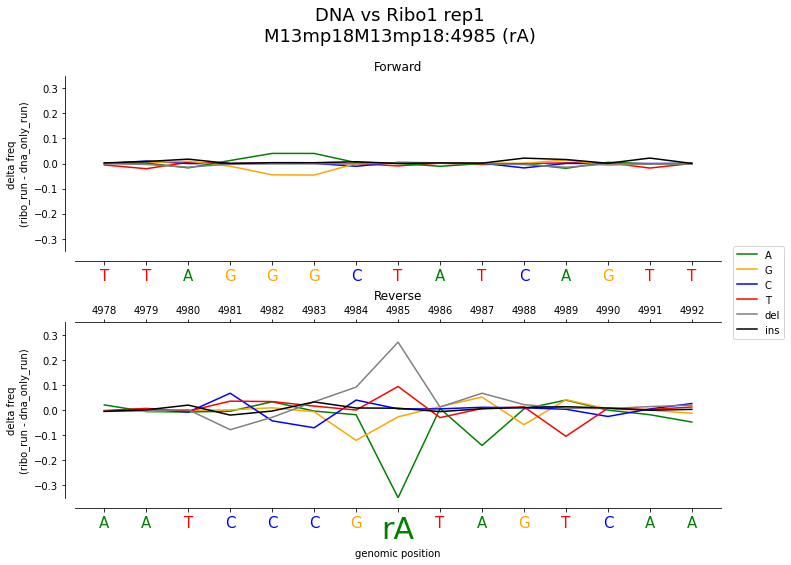

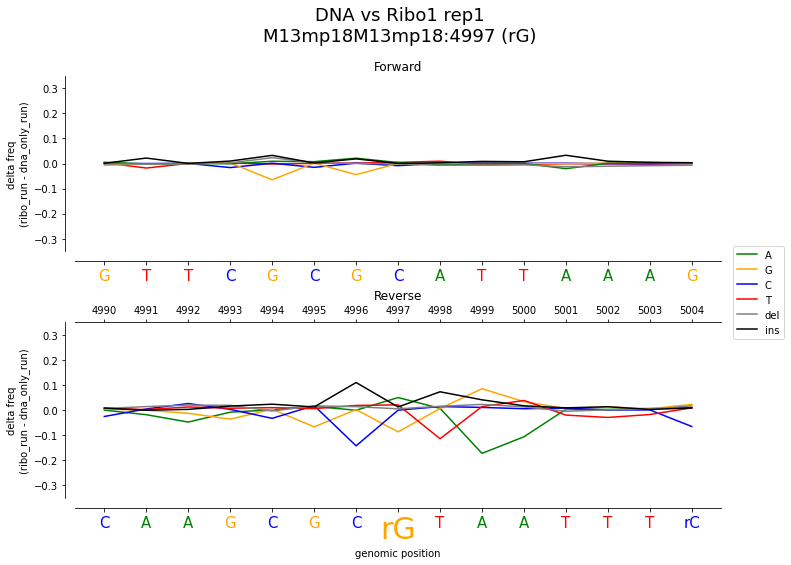

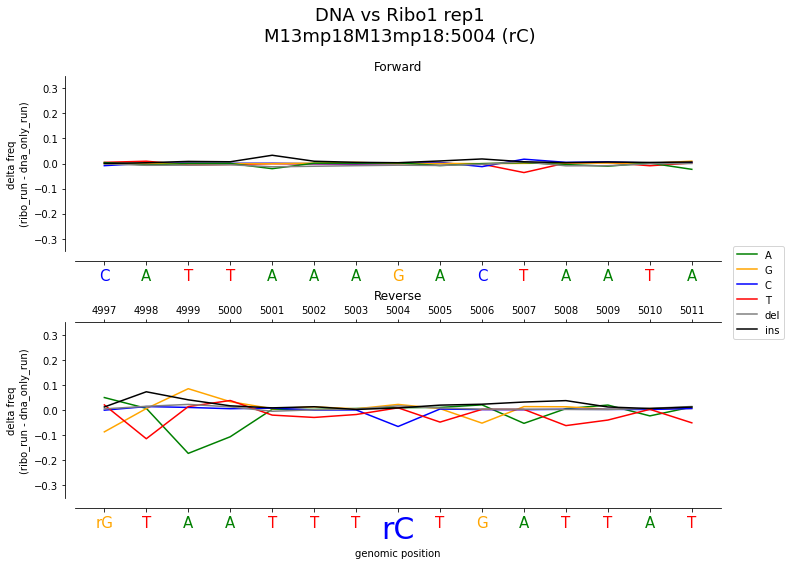

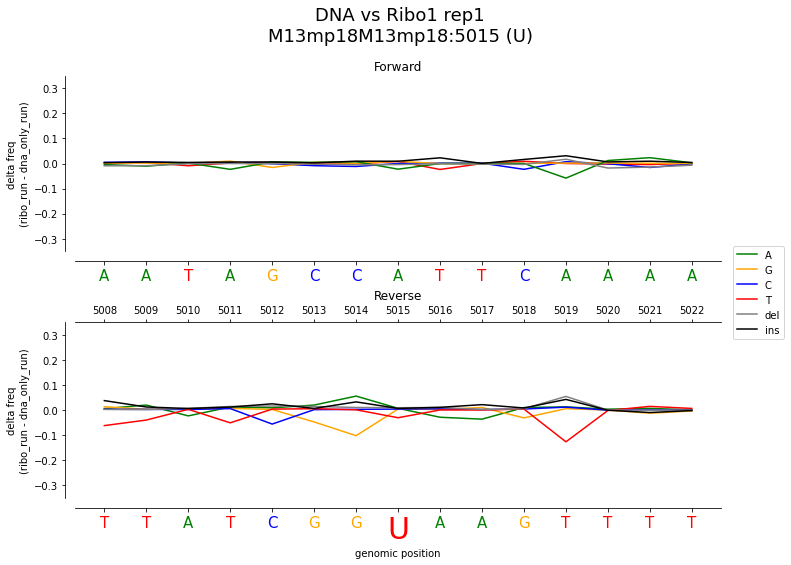

In [4]:
# open reference with pysam as FastaFile object
ref = pysam.FastaFile(reference_filepath)

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4985, 4997, 5004, 5015]

# define ribo names
ribos = ["rA", "rG", "rC", "U"]

# define color code
color_code = {"A":"green", "G":"orange", "C":"blue", "T":"red", "rA":"green", "rG":"orange", "rC":"blue", "U":"red", "ins":"black", "del":"gray"}

# load alignment profiles for dna and ribo for each expected "ribo" site
columns_forw = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'T', 'C', 'G', 'A', 'del', 'ins']
columns_rev = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'A', 'G', 'C', 'T', 'del', 'ins']
for ribo, site in zip(ribos, sites):
    dna_forw = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.dna.forw.tsv"))[0], index_col=0)
    dna_forw.columns = columns_forw
    dna_rev = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.dna.rev.tsv"))[0], index_col=0)
    dna_rev.columns = columns_rev
    ribo_forw = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.ribo.forw.tsv"))[0], index_col=0)
    ribo_forw.columns = columns_forw
    ribo_rev = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.ribo.rev.tsv"))[0], index_col=0)
    ribo_rev.columns = columns_rev
    
    # calculate differential frequencies between dna_only and ribo runs at each strand
    forw_freqs_diffs = (ribo_forw.iloc[:,-6:] - dna_forw.iloc[:,-6:])
    rev_freqs_diffs = (ribo_rev.iloc[:,-6:] - dna_rev.iloc[:,-6:])
    
    # retrieve reference sequences
    start, stop = forw_freqs_diffs.index.min()-1, forw_freqs_diffs.index.max()
    seq = ref.fetch("M13mp18", start, stop)
    seq_rev_compl = get_complement(seq)
    
    # convert to lists
    seq = list(seq)
    seq_rev_compl = list(seq_rev_compl)
    # change central base since it is an expected nucleotide
    if not seq_rev_compl[7] == "T":
        seq_rev_compl[7] = "r"+seq_rev_compl[7]
    else:
        seq_rev_compl[7] = "U"
    # considers sites 4997 and 5004 are in overlap
    if site == 4997:
        seq_rev_compl[-1] = "rC"
    elif site == 5004:
        seq_rev_compl[0] = "rG"
    
    # take maximum absolute values of differences in both strand to be used to determine y intervals into plots
    max_abs_freq  = max(forw_freqs_diffs.abs().max().max(), rev_freqs_diffs.abs().max().max())
    if max_abs_freq < 0.35:
        max_abs_freq = 0.35
    
    ### plot differential alignment profiles
    # create a subplot for each site
    f, axes = plt.subplots(2, figsize=(10,7), constrained_layout=True)
    
    # plot forward strand
    #axes[0].axhline(0,0,1, linewidth=0.5, color="gray")
    # change index labels
    forw_freqs_diffs.index = seq
    forw_freqs_diffs.plot(ax=axes[0], color=[color_code[i] for i in forw_freqs_diffs.columns])
    axes[0].set_title("Forward")
    axes[0].set_ylim([-max_abs_freq, max_abs_freq])
    axes[0].legend().set_visible(False)
    # Move left and bottom spines outward by 10 points
    axes[0].spines.left.set_position(('outward', 10))
    axes[0].spines.bottom.set_position(('outward', 10))
    # Hide the right and top spines
    axes[0].spines.right.set_visible(False)
    axes[0].spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[0].yaxis.set_ticks_position('left')
    axes[0].xaxis.set_ticks_position('bottom')
    axes[0].set_ylabel("delta freq\n(ribo_run - dna_only_run)")
    axes[0].set_xticks(range(len(forw_freqs_diffs.index)))
    axes[0].set_xticklabels(forw_freqs_diffs.index)
    # changes tick colors
    my_colors = [color_code[base] for base in seq]
    for ticklabel, tickcolor in zip(axes[0].get_xticklabels(), my_colors):
        ticklabel.set_color(tickcolor)
        ticklabel.set_size(15)
        
    # plot reverse strand
    #axes[1].axhline(0,0,1, linewidth=0.5, color="gray")
    # change index labels
    rev_freqs_diffs.index = seq_rev_compl
    rev_freqs_diffs.plot(ax=axes[1], color=[color_code[i] for i in rev_freqs_diffs.columns])
    axes[1].set_title("Reverse")
    axes[1].set_ylim([-max_abs_freq, max_abs_freq])
    axes[1].legend().set_visible(False)
    # Move left and bottom spines outward by 10 points
    axes[1].spines.left.set_position(('outward', 10))
    axes[1].spines.bottom.set_position(('outward', 10))
    # Hide the right and top spines
    axes[1].spines.right.set_visible(False)
    axes[1].spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[1].yaxis.set_ticks_position('left')
    axes[1].xaxis.set_ticks_position('bottom')
    axes[1].set_xlabel("genomic position")
    axes[1].set_ylabel("delta freq\n(ribo_run - dna_only_run)")
    
    # change tick colors and sizes
    axes[1].set_xticks(range(len(rev_freqs_diffs.index)))
    axes[1].set_xticklabels(rev_freqs_diffs.index)
    my_colors = [color_code[base] for base in seq_rev_compl]
    for ticklabel, tickcolor in zip(axes[1].get_xticklabels(), my_colors):
        ticklabel.set_color(tickcolor)
        ticklabel.set_size(15)
    # increase size for ribonucleotide
    axes[1].get_xticklabels()[7].set_size(30)
    
    # set second xaxis
    secax = axes[1].secondary_xaxis("top")
    secax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    secax.set_xticklabels([f"{x}" for x in range(start+1,stop+1)])
    
    # set suptitle and legend position
    f.suptitle(f"DNA vs Ribo1 rep1\nM13mp18M13mp18:{site} ({ribo})", x=0.55, y=1.1, fontsize=18)
    
    # change legend labels and colors
    handles, labels = axes[1].get_legend_handles_labels()
    l = f.legend(handles, labels, bbox_to_anchor=(1.09, 0.635))
    for text, col in zip(l.get_texts(), l.legendHandles):
        col.set_color(color_code[text.get_text()])

    # save image to disk
    plt.savefig(os.path.join(results_folder_diff_plots, f"LINEPLOT_DIFF_DNAonly_vs_Ribo1_rep1_site_M13mp18:{site}.tiff"), 
                dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    
    # plot resulting image
    plt.show()

# close reference file
ref.close()

Version with aggregated data.
First of all there is the need for the calculation of mismatches frequencies with respect the expected base and then we need to sum frequencies of mismatches and indels together. Thus we can do a substraction between dna_only and ribo runs for each strand.

In [5]:
# create a function to compute total noise
def compute_noise(query_df):
    query_df = query_df.iloc[:,-6:].copy()
    # retrieve seqs
    ref = pysam.FastaFile(reference_filepath)
    ref_seq = []
    for pos in query_df.index:
        base = ref.fetch("M13mp18", pos-1, pos)
        ref_seq.append(base)
    query_df["ref"] = ref_seq
    ref.close()

    # compute total noise:
    total_noise = []
    for pos in query_df.index:
        df_pos = query_df.loc[pos]
        df_pos = df_pos.drop(df_pos["ref"])
        total_noise.append(df_pos.to_frame().iloc[:-1].sum().values[0])
    query_df["total_noise"] = total_noise
    query_df.drop("ref", inplace=True, axis=1)
    
    return query_df

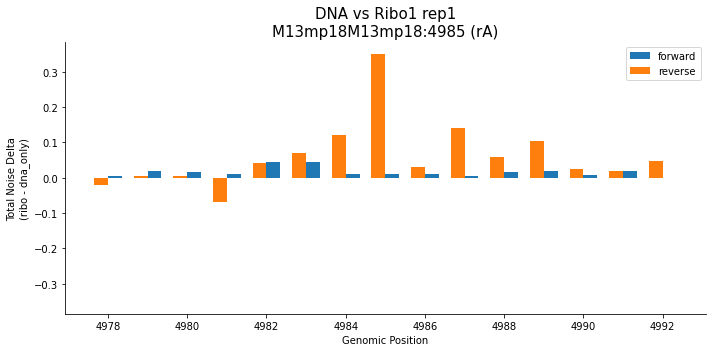

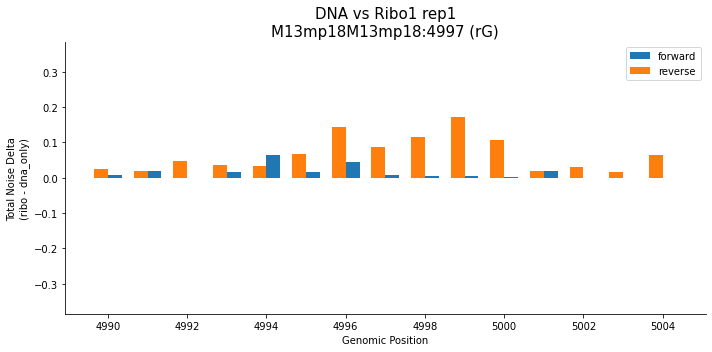

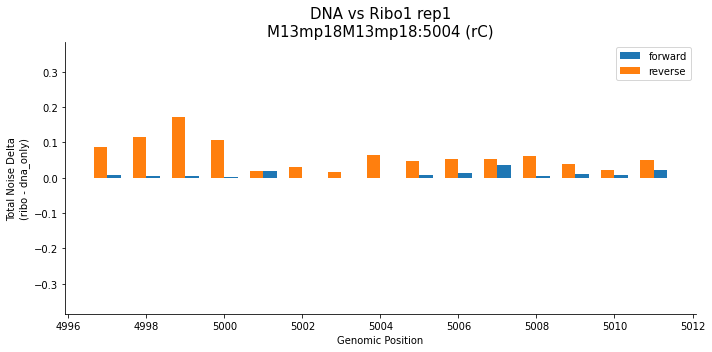

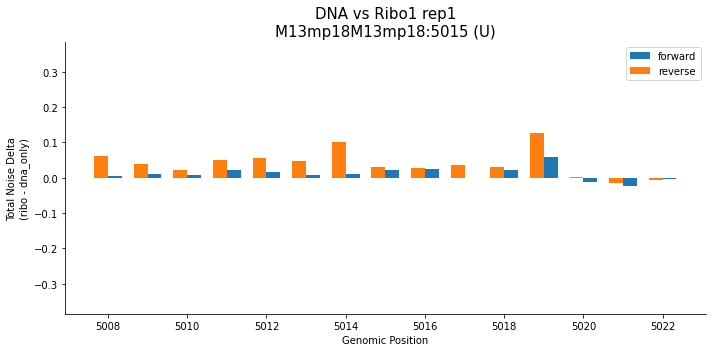

In [6]:
# open reference with pysam as FastaFile object
ref = pysam.FastaFile(reference_filepath)

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4985, 4997, 5004, 5015]

# define ribo names
ribos = ["rA", "rG", "rC", "U"]

# define color code
color_code = {"A":"green", "G":"orange", "C":"blue", "T":"red", "rA":"green", "rG":"orange", "rC":"blue", "U":"red", "ins":"black", "del":"gray"}

# load alignment profiles for dna and ribo for each expected "ribo" site
columns_forw = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'T', 'C', 'G', 'A', 'del', 'ins']
columns_rev = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'T', 'C', "G", 'A', 'del', 'ins']
for ribo, site in zip(ribos, sites):
    dna_forw = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.dna.forw.tsv"))[0], index_col=0)
    dna_forw.columns = columns_forw
    dna_forw = compute_noise(dna_forw.iloc[:,-6:])
    dna_rev = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.dna.rev.tsv"))[0], index_col=0)
    dna_rev.columns = columns_rev
    dna_rev = compute_noise(dna_rev.iloc[:,-6:])
    ribo_forw = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.ribo.forw.tsv"))[0], index_col=0)
    ribo_forw.columns = columns_forw
    ribo_forw = compute_noise(ribo_forw.iloc[:,-6:])
    ribo_rev = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 site M13mp18:{site}.ribo.rev.tsv"))[0], index_col=0)
    ribo_rev.columns = columns_rev
    ribo_rev = compute_noise(ribo_rev.iloc[:,-6:])
    
    # calculate differential frequencies between dna_only and ribo runs at each strand (only total noise)
    forw_freqs_diffs = (ribo_forw["total_noise"] - dna_forw["total_noise"]).to_frame()
    rev_freqs_diffs = (ribo_rev["total_noise"] - dna_rev["total_noise"]).to_frame()
    
    # retrieve reference sequences
    start, stop = forw_freqs_diffs.index.min()-1, forw_freqs_diffs.index.max()
    seq = ref.fetch("M13mp18", start, stop)
    seq_rev_compl = get_complement(seq)
    
    # convert to lists
    seq = list(seq)
    seq_rev_compl = list(seq_rev_compl)
    # change central base since it is an expected nucleotide
    if not seq_rev_compl[7] == "T":
        seq_rev_compl[7] = "r"+seq_rev_compl[7]
    else:
        seq_rev_compl[7] = "U"
    # considers sites 4997 and 5004 are in overlap
    if site == 4997:
        seq_rev_compl[-1] = "rC"
    elif site == 5004:
        seq_rev_compl[0] = "rG"
    
    forw_freqs_diffs["ref"] = seq
    rev_freqs_diffs["ref"] = seq_rev_compl
    
    # take maximum absolute values of differences in both strand to be used to determine y intervals into plots
    max_abs_freq  = max(forw_freqs_diffs.total_noise.max(), rev_freqs_diffs.total_noise.max())
    if max_abs_freq < 0.35:
        max_abs_freq = 0.35
    
    plt.figure(figsize=(10,5))
    width = 0.35
    plt.bar(x=forw_freqs_diffs.index+width/2, height=forw_freqs_diffs.total_noise, width=width, label="forward")
    plt.bar(x=rev_freqs_diffs.index-width/2, height=rev_freqs_diffs.total_noise, width=width, label="reverse")
    plt.legend()
    plt.title(f"DNA vs Ribo1 rep1\nM13mp18M13mp18:{site} ({ribo})", size=15)
    plt.xlabel("Genomic Position")
    plt.ylabel("Total Noise Delta\n(ribo - dna_only)")
    plt.ylim(-max_abs_freq*1.1, max_abs_freq*1.1)
    sn.despine()
    plt.tight_layout()
    
    # save image to disk
    plt.savefig(os.path.join(results_folder_diff_plots, f"TOTAL_NOISE_BARPLOT_DIFF_DNAonly_vs_Ribo1_rep1_site_M13mp18:{site}.tiff"), 
                dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    
    # show image
    plt.show()

# close reference file
ref.close()

## DNA vs Ribo1 rep2 09 07 2022

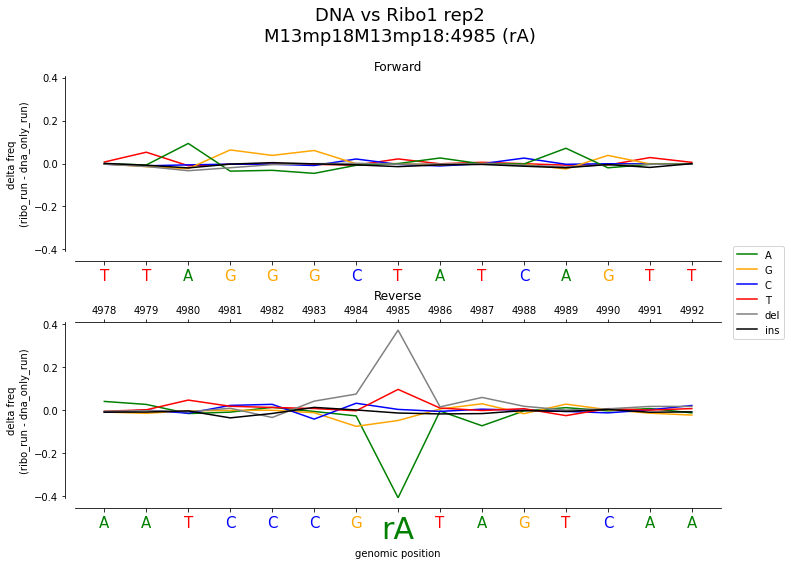

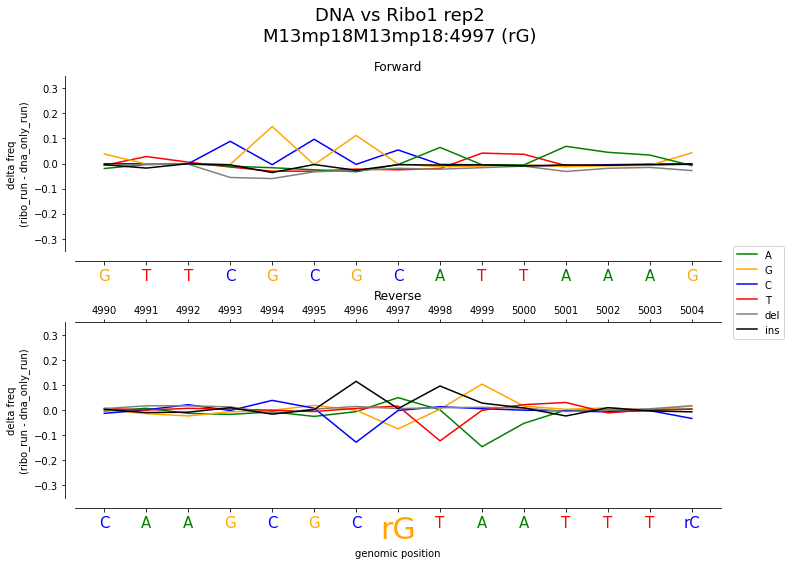

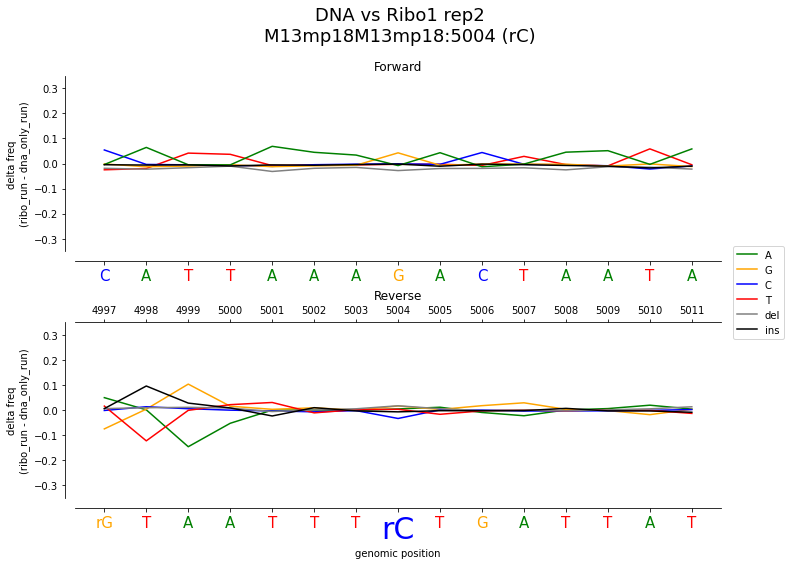

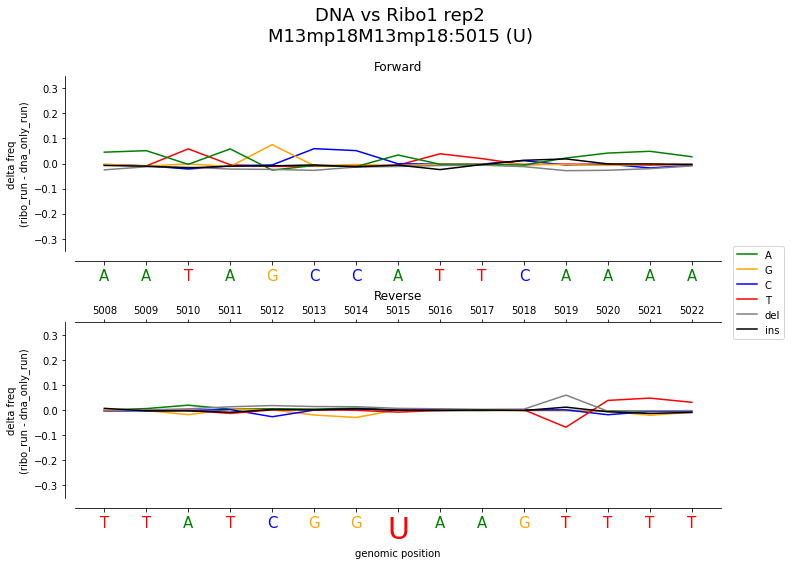

In [7]:
# open reference with pysam as FastaFile object
ref = pysam.FastaFile(reference_filepath)

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4985, 4997, 5004, 5015]

# define ribo names
ribos = ["rA", "rG", "rC", "U"]

# define color code
color_code = {"A":"green", "G":"orange", "C":"blue", "T":"red", "rA":"green", "rG":"orange", "rC":"blue", "U":"red", "ins":"black", "del":"gray"}

# load alignment profiles for dna and ribo for each expected "ribo" site
columns_forw = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'T', 'C', 'G', 'A', 'del', 'ins']
columns_rev = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'A', 'G', 'C', 'T', 'del', 'ins']
for ribo, site in zip(ribos, sites):
    dna_forw = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 rep2 site M13mp18:{site}.dna.forw.tsv"))[0], index_col=0)
    dna_forw.columns = columns_forw
    dna_rev = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 rep2 site M13mp18:{site}.dna.rev.tsv"))[0], index_col=0)
    dna_rev.columns = columns_rev
    ribo_forw = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 rep2 site M13mp18:{site}.ribo.forw.tsv"))[0], index_col=0)
    ribo_forw.columns = columns_forw
    ribo_rev = pd.read_table(glob.glob(os.path.join(results_folder, f"DNA only vs Ribo1 rep2 site M13mp18:{site}.ribo.rev.tsv"))[0], index_col=0)
    ribo_rev.columns = columns_rev
    
    # calculate differential frequencies between dna_only and ribo runs at each strand
    forw_freqs_diffs = (ribo_forw.iloc[:,-6:] - dna_forw.iloc[:,-6:])
    rev_freqs_diffs = (ribo_rev.iloc[:,-6:] - dna_rev.iloc[:,-6:])
    
    # retrieve reference sequences
    start, stop = forw_freqs_diffs.index.min()-1, forw_freqs_diffs.index.max()
    seq = ref.fetch("M13mp18", start, stop)
    seq_rev_compl = get_complement(seq)
    
    # convert to lists
    seq = list(seq)
    seq_rev_compl = list(seq_rev_compl)
    # change central base since it is an expected nucleotide
    if not seq_rev_compl[7] == "T":
        seq_rev_compl[7] = "r"+seq_rev_compl[7]
    else:
        seq_rev_compl[7] = "U"
    # considers sites 4997 and 5004 are in overlap
    if site == 4997:
        seq_rev_compl[-1] = "rC"
    elif site == 5004:
        seq_rev_compl[0] = "rG"
    
    # take maximum absolute values of differences in both strand to be used to determine y intervals into plots
    max_abs_freq  = max(forw_freqs_diffs.abs().max().max(), rev_freqs_diffs.abs().max().max())
    if max_abs_freq < 0.35:
        max_abs_freq = 0.35
    
    ### plot differential alignment profiles
    # create a subplot for each site
    f, axes = plt.subplots(2, figsize=(10,7), constrained_layout=True)
    
    # plot forward strand
    #axes[0].axhline(0,0,1, linewidth=0.5, color="gray")
    # change index labels
    forw_freqs_diffs.index = seq
    forw_freqs_diffs.plot(ax=axes[0], color=[color_code[i] for i in forw_freqs_diffs.columns])
    axes[0].set_title("Forward")
    axes[0].set_ylim([-max_abs_freq, max_abs_freq])
    axes[0].legend().set_visible(False)
    # Move left and bottom spines outward by 10 points
    axes[0].spines.left.set_position(('outward', 10))
    axes[0].spines.bottom.set_position(('outward', 10))
    # Hide the right and top spines
    axes[0].spines.right.set_visible(False)
    axes[0].spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[0].yaxis.set_ticks_position('left')
    axes[0].xaxis.set_ticks_position('bottom')
    axes[0].set_ylabel("delta freq\n(ribo_run - dna_only_run)")
    axes[0].set_xticks(range(len(forw_freqs_diffs.index)))
    axes[0].set_xticklabels(forw_freqs_diffs.index)
    # changes tick colors
    my_colors = [color_code[base] for base in seq]
    for ticklabel, tickcolor in zip(axes[0].get_xticklabels(), my_colors):
        ticklabel.set_color(tickcolor)
        ticklabel.set_size(15)
        
    # plot reverse strand
    #axes[1].axhline(0,0,1, linewidth=0.5, color="gray")
    # change index labels
    rev_freqs_diffs.index = seq_rev_compl
    rev_freqs_diffs.plot(ax=axes[1], color=[color_code[i] for i in rev_freqs_diffs.columns])
    axes[1].set_title("Reverse")
    axes[1].set_ylim([-max_abs_freq, max_abs_freq])
    axes[1].legend().set_visible(False)
    # Move left and bottom spines outward by 10 points
    axes[1].spines.left.set_position(('outward', 10))
    axes[1].spines.bottom.set_position(('outward', 10))
    # Hide the right and top spines
    axes[1].spines.right.set_visible(False)
    axes[1].spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[1].yaxis.set_ticks_position('left')
    axes[1].xaxis.set_ticks_position('bottom')
    axes[1].set_xlabel("genomic position")
    axes[1].set_ylabel("delta freq\n(ribo_run - dna_only_run)")
    
    # change tick colors and sizes
    axes[1].set_xticks(range(len(rev_freqs_diffs.index)))
    axes[1].set_xticklabels(rev_freqs_diffs.index)
    my_colors = [color_code[base] for base in seq_rev_compl]
    for ticklabel, tickcolor in zip(axes[1].get_xticklabels(), my_colors):
        ticklabel.set_color(tickcolor)
        ticklabel.set_size(15)
    # increase size for ribonucleotide
    axes[1].get_xticklabels()[7].set_size(30)
    
    # set second xaxis
    secax = axes[1].secondary_xaxis("top")
    secax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    secax.set_xticklabels([f"{x}" for x in range(start+1,stop+1)])
    
    # set suptitle and legend position
    f.suptitle(f"DNA vs Ribo1 rep2\nM13mp18M13mp18:{site} ({ribo})", x=0.55, y=1.1, fontsize=18)
    
    # change legend labels and colors
    handles, labels = axes[1].get_legend_handles_labels()
    l = f.legend(handles, labels, bbox_to_anchor=(1.09, 0.635))
    for text, col in zip(l.get_texts(), l.legendHandles):
        col.set_color(color_code[text.get_text()])

    # save image to disk
    plt.savefig(os.path.join(results_folder_diff_plots, f"LINEPLOT_DIFF_DNAonly_vs_Ribo1_rep2_site_M13mp18:{site}.tiff"), 
                dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    
    # plot resulting image
    plt.show()

# close reference file
ref.close()